In [104]:
%matplotlib inline
 
import numpy as np
import pandas as pd
import sklearn as sk
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import graphviz # needed to visualize trained decision tree [optional]
from sklearn.tree import export_graphviz # needed to visualize trained decision tree

We begin with reading in our data and doing some initial cleaning.

In [105]:
# Read in data
data = pd.read_csv('data.csv')

# Filter out new data
data_current = data[data.year >= 2010]

# Remove duplicate values based on id
data_current = data_current.drop_duplicates(subset=['id'],keep='first',inplace=False)
data_current.shape # shape matches what we have in R; we're good here.

(26711, 19)

In [106]:
# Creating a new popularity dummy variable
def groups(series):
    if 75 <= series <= 100:
        return 2
    elif 25 <= series < 75:
        return 1
    elif series < 25:
        return 0
data_current['popDummy'] = data_current['popularity'].apply(groups)

# Converting duration_ms to seconds
data_current['duration_s'] = data_current['duration_ms']*.001

# Recoding year variable
def groups(series):
    if series == 2010:
        return 0
    elif series == 2011:
        return 1
    elif series == 2012:
        return 2
    elif series == 2013:
        return 3
    elif series == 2014:
        return 4
    elif series == 2015:
        return 5
    elif series == 2016:
        return 6
    elif series == 2017:
        return 7
    elif series == 2018:
        return 8
    elif series == 2019:
        return 9
    elif series == 2020:
        return 10
    elif series == 2021:
        return 11
data_current['year_factor'] = data_current['year'].apply(groups)

#list(data_current)
#data_current['loudness']

In [107]:
# Looking at correlation w/ popDummy

temp_data = data_current.copy()
temp_data.drop(['popularity', 'duration_ms', 'year'],axis = 1, inplace = True)
temp = abs(data_current.corr()['popDummy'].sort_values(ascending = False))
temp.sort_values(ascending = False)


popDummy            1.000000
popularity          0.942463
instrumentalness    0.390300
explicit            0.331834
loudness            0.178684
liveness            0.126425
duration_ms         0.118033
duration_s          0.118033
danceability        0.104003
energy              0.100440
acousticness        0.064767
year_factor         0.059366
year                0.059366
tempo               0.055765
speechiness         0.051722
valence             0.041528
key                 0.030805
mode                0.027260
Name: popDummy, dtype: float64

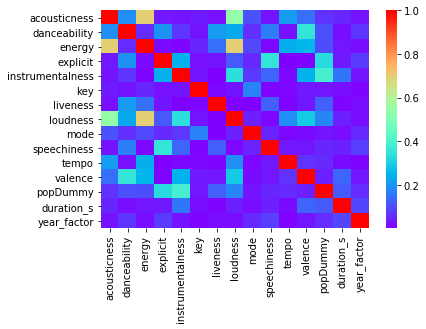

In [108]:
# Correlation matrix
sns.heatmap(abs(temp_data.corr()), cmap = 'rainbow');

In [109]:
# Subsetting our data to use for model--let's call this 'spotify'
spotify = data_current[['popDummy','instrumentalness','explicit','loudness','duration_s','liveness','danceability','year_factor']]

# We're going to only use data from 2010-2021, and predict 2021.
spotify_new = spotify[spotify.year_factor == 11]
spotify = spotify[spotify.year_factor < 11]

# Just a quick look-through to make sure the data is good
print(spotify.head())

      popDummy  instrumentalness  explicit  loudness  duration_s  liveness  \
9087         1          0.000000         0   -17.796     187.333    0.9040   
9091         1          0.000005         0   -18.168     236.800    0.6830   
9111         0          0.000022         0   -14.118     313.093    0.7980   
9117         0          0.000162         0   -15.533     295.093    0.0986   
9119         0          0.000015         0   -14.087     183.440    0.1470   

      danceability  year_factor  
9087         0.319            8  
9091         0.269            8  
9111         0.644           10  
9117         0.627           10  
9119         0.581           10  


In [110]:
print(list(spotify.columns))

['popDummy', 'instrumentalness', 'explicit', 'loudness', 'duration_s', 'liveness', 'danceability', 'year_factor']


In [111]:
print(spotify.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25318 entries, 9087 to 174188
Data columns (total 8 columns):
popDummy            25318 non-null int64
instrumentalness    25318 non-null float64
explicit            25318 non-null int64
loudness            25318 non-null float64
duration_s          25318 non-null float64
liveness            25318 non-null float64
danceability        25318 non-null float64
year_factor         25318 non-null int64
dtypes: float64(5), int64(3)
memory usage: 1.7 MB
None


Things to consider:
    - change instrumentalness variable to factor?
    - ensure explicit, key, mode, and year are factors

MODEL SELECTION

In [112]:
train, test = train_test_split(spotify, test_size = 0.2, random_state = 123)

# Creating dataframes for the training/test inputs/target
train_X = train.drop(['popDummy'], axis=1)
train_Y = train["popDummy"]
test_X = test.drop(['popDummy'], axis=1)
test_Y = test["popDummy"]

test_Y.size

5064

In [113]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20254 entries, 75235 to 142971
Data columns (total 7 columns):
instrumentalness    20254 non-null float64
explicit            20254 non-null int64
loudness            20254 non-null float64
duration_s          20254 non-null float64
liveness            20254 non-null float64
danceability        20254 non-null float64
year_factor         20254 non-null int64
dtypes: float64(5), int64(2)
memory usage: 1.2 MB


1. Multinomial logisitic regression

In [114]:
# Declare model
lr_model = LogisticRegression()

# Fitting model on training data
lr_model.fit(train_X,train_Y)

# Printing our our predicted values
Y_hat = lr_model.predict(test_X)
#with np.printoptions(threshold=np.inf):
#    print(Y_hat)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [115]:
# confusion matrix
conf_matrix = confusion_matrix(test_Y,Y_hat)
print(conf_matrix)

[[2233  590    2]
 [ 607 1345    8]
 [ 133  143    3]]


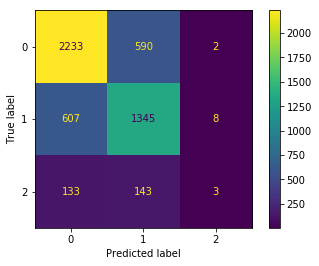

In [116]:
plot_confusion_matrix(lr_model, test_X, test_Y)

In [117]:
# classification report
print(classification_report(Y_hat,test_Y))
# warning; most likely due to all predictions being 0

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      2973
           1       0.69      0.65      0.67      2078
           2       0.01      0.23      0.02        13

    accuracy                           0.71      5064
   macro avg       0.50      0.54      0.49      5064
weighted avg       0.75      0.71      0.73      5064



In [118]:
# accuracy measure
print(accuracy_score(Y_hat,test_Y))

0.7071484992101106


2. kNN 

In [120]:
# First find the optimal # of neighbors
scores = []
for i in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors = i)
    knn_model.fit(train_X, train_Y)
    y_model = knn_model.predict(test_X)
    scores.append(accuracy_score(test_Y, y_model))
    
max_val = max(scores)
print(max_val, scores.index(max_val))

0.691350710900474 18


In [121]:
k = scores.index(max_val)

# Create model object
knn_model = KNeighborsClassifier(k)

# Train model
knn_model.fit(train_X, train_Y)

# Test model
Y_hat = knn_model.predict(test_X)

# Printing our our predicted values
#with np.printoptions(threshold=np.inf):
#    print(Y_hat)

In [122]:
# confusion matrix
conf_matrix = confusion_matrix(test_Y, Y_hat)
print(conf_matrix)

[[2249  555   21]
 [ 741 1200   19]
 [ 138  122   19]]


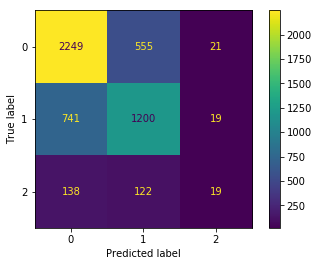

In [123]:
plot_confusion_matrix(knn_model, test_X, test_Y)

In [124]:
# classification report
print(classification_report(test_Y, Y_hat))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76      2825
           1       0.64      0.61      0.63      1960
           2       0.32      0.07      0.11       279

    accuracy                           0.68      5064
   macro avg       0.56      0.49      0.50      5064
weighted avg       0.67      0.68      0.67      5064



In [125]:
# accuracy measure
print("Accuracy: ", accuracy_score(test_Y,Y_hat))

Accuracy:  0.6848341232227488


3. Classification tree

In [126]:
## Let's train models over a range of depths, and score them with the test set
from sklearn.metrics import f1_score

acc_scores = [] # accuracy scores
f1_scores = [] # F1-scores
max_max = 20 # maximum depth
max_depth = np.arange(1, max_max) # range of 1:20 of depths to try

for depth in max_depth:
    # Build model and train
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=123) # not tuning # samples per leaf. setting random seed
    tree_model.fit(train_X, train_Y)

    # Test
    acc_scores.append(tree_model.score(test_X, test_Y))
    y_test_hat = tree_model.predict(test_X)
    f1_scores.append(f1_score(test_Y, y_test_hat, average=None))
    #^ need to add average parameter to f1-score since this is a multi-class problem

# Print values for best test score
ix_best = np.argmax(acc_scores)
print('Best accuracy score is %0.3f, for max_depth=%d' % (acc_scores[ix_best], max_depth[ix_best]))
ix_best = np.argmax(f1_scores)
from sklearn.metrics import f1_score

acc_scores = [] # accuracy scores
f1_scores = [] # F1-scoresprint('Best F1-score is %0.3f, for max_depth=%d' % (f1_scores[ix_best], max_depth[ix_best]))

Best accuracy score is 0.746, for max_depth=10


In [127]:
# Classification tree

# Declare model w/ depth of best accuracy score
tree_model = DecisionTreeClassifier(max_depth=10, random_state=123)

# Train model
tree_model.fit(train_X, train_Y)

# Printing our our predicted values w/ depth of best accuracy score
Y_hat = tree_model.predict(test_X)
#with np.printoptions(threshold=np.inf):
#    print(Y_hat)

In [128]:
# confusion matrix
conf_matrix = confusion_matrix(test_Y, Y_hat)
print(conf_matrix)

[[2319  490   16]
 [ 507 1428   25]
 [  90  160   29]]


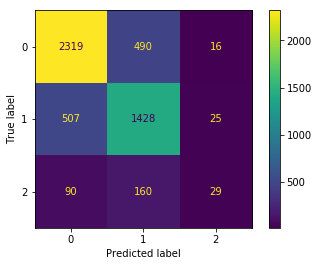

In [129]:
plot_confusion_matrix(tree_model, test_X, test_Y)

In [130]:
# classification report
print(classification_report(test_Y, Y_hat))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2825
           1       0.69      0.73      0.71      1960
           2       0.41      0.10      0.17       279

    accuracy                           0.75      5064
   macro avg       0.63      0.55      0.56      5064
weighted avg       0.73      0.75      0.73      5064



In [131]:
# accuracy measure
print("Accuracy: ", accuracy_score(test_Y,Y_hat))

Accuracy:  0.7456556082148499


Testing our models on 2021 data:

In [132]:
X = spotify_new.drop(['popDummy'], axis=1)
Y = spotify_new['popDummy']


In [133]:

# Logistic regression
# Printing our our predicted values
Y_hat = lr_model.predict(X)
#with np.printoptions(threshold=np.inf):
#    print(Y_hat)

In [134]:
# confusion matrix
conf_matrix = confusion_matrix(Y, Y_hat)
print(conf_matrix)

[[1093   82   17]
 [ 135   29   11]
 [  18    5    3]]


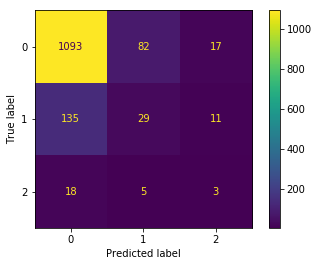

In [135]:
plot_confusion_matrix(lr_model, X, Y)

In [136]:
# classification report
print(classification_report(Y, Y_hat))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1192
           1       0.25      0.17      0.20       175
           2       0.10      0.12      0.11        26

    accuracy                           0.81      1393
   macro avg       0.41      0.40      0.40      1393
weighted avg       0.78      0.81      0.79      1393



In [137]:
# accuracy measure
print("Accuracy: ", accuracy_score(Y,Y_hat))

Accuracy:  0.8076094759511845


In [138]:
# kNN, k = 18
# Printing our our predicted values
Y_hat = knn_model.predict(X)
#with np.printoptions(threshold=np.inf):
#    print(Y_hat)

In [139]:
# confusion matrix
conf_matrix = confusion_matrix(Y, Y_hat)
print(conf_matrix)

[[1024   60  108]
 [ 126   22   27]
 [  12    6    8]]


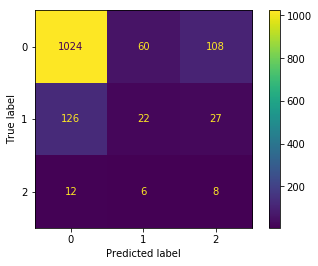

In [140]:
plot_confusion_matrix(knn_model, X, Y)

In [141]:
# classification report
print(classification_report(Y, Y_hat))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1192
           1       0.25      0.13      0.17       175
           2       0.06      0.31      0.09        26

    accuracy                           0.76      1393
   macro avg       0.40      0.43      0.38      1393
weighted avg       0.79      0.76      0.77      1393



In [142]:
# accuracy measure
print("Accuracy: ", accuracy_score(Y,Y_hat))

Accuracy:  0.756640344580043


In [145]:
# Classification tree

Y_hat = tree_model.predict(X)
#with np.printoptions(threshold=np.inf):
#    print(Y_hat)

In [147]:
# confusion matrix
conf_matrix = confusion_matrix(Y, Y_hat)
print(conf_matrix)

[[1038   84   70]
 [ 128   19   28]
 [  18    3    5]]


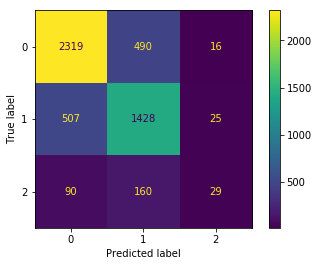

In [148]:
plot_confusion_matrix(tree_model, test_X, test_Y)

In [151]:
# classification report
print(classification_report(Y, Y_hat))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1192
           1       0.18      0.11      0.14       175
           2       0.05      0.19      0.08        26

    accuracy                           0.76      1393
   macro avg       0.37      0.39      0.36      1393
weighted avg       0.77      0.76      0.77      1393



In [152]:
# accuracy measure
print("Accuracy: ", accuracy_score(Y,Y_hat))

Accuracy:  0.7623833452979182


Looks like kNN performs best! We were able to predict the 2021 songs' groups with around 75% accuracy.